In [1]:
import pandas as pd
import numpy as np
from fastai.vision.all import *
import pickle
import os

In [2]:
train_df = pd.read_csv('C:/Users/avina/Desktop/HPA/cell_train_df.csv')
train_df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [3]:
len(train_df)

181997

In [4]:
labels = [str(i) for i in range(19)]
for x in labels: 
    train_df[x] = train_df['image_labels'].apply(lambda r: int(x in r.split('|')))

In [5]:
train_dfs = train_df.sample(frac=0.30, random_state=42)
train_dfs = train_dfs.reset_index(drop=True)
len(train_dfs)

36399

In [6]:
df_11 = train_df[train_df['image_labels']=='10|11'][0:10]
df_11['image_labels'] = ['11']*10
df_11

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2,0,1,...,9,10,11,12,13,14,15,16,17,18
108558,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.018905,0.013184,0.057968,1,11,454,268,0,0,...,0,1,1,0,0,0,0,0,0,0
108559,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.029468,0.021559,0.091387,2,11,363,350,0,0,...,0,1,1,0,0,0,0,0,0,0
108560,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.059497,0.031760,0.078411,3,11,348,483,0,0,...,0,1,1,0,0,0,0,0,0,0
108561,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.119210,0.032153,0.033568,4,11,102,202,0,0,...,0,1,1,0,0,0,0,0,0,0
108562,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.108884,0.024860,0.028614,5,11,197,221,0,0,...,0,1,1,0,0,0,0,0,0,0
108563,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.080185,0.025438,0.041298,6,11,138,314,0,0,...,0,1,1,0,0,0,0,0,0,0
108564,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.030084,0.016588,0.038453,7,11,402,449,0,0,...,0,1,1,0,0,0,0,0,0,0
108565,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.041067,0.021704,0.039592,8,11,407,345,0,0,...,0,1,1,0,0,0,0,0,0,0
108566,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.076076,0.024370,0.050490,9,11,450,474,0,0,...,0,1,1,0,0,0,0,0,0,0
108567,258850ec-bba6-11e8-b2ba-ac1f6b6435d0,0.074050,0.028954,0.054094,10,11,305,291,0,0,...,0,1,1,0,0,0,0,0,0,0


In [7]:
train_dfs = pd.concat((train_dfs, df_11))

In [8]:
unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(train_dfs[train_dfs.image_labels == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in train_dfs['image_labels']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'full_count', 'unique_count'])
counts.set_index('label').T

label,0,16,2,13,12,5,14,7,3,4,1,8,6,17,10,9,15,11,18
full_count,4108,3584,2968,2899,2853,2782,2722,2669,2547,2393,2238,2188,2062,2039,2023,1865,1290,434,188
unique_count,1448,1866,2436,2139,2577,2441,2610,2467,2342,2217,970,2087,1318,948,1192,874,488,10,188


In [9]:
nfold = 5

y = train_dfs[labels].values
X = train_dfs[['image_id', 'cell_id']].values

train_dfs['fold'] = np.nan

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, shuffle=True, random_state=None)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_dfs.iloc[test_index, -1] = i
    
train_dfs['fold'] = train_dfs['fold'].astype('int')

C:\Users\avina\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [10]:
train_dfs['is_valid'] = False
train_dfs['is_valid'][train_dfs['fold'] == 0] = True

<ipython-input-10-587b06393aaf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dfs['is_valid'][train_dfs['fold'] == 0] = True


In [11]:
train_dfs.is_valid.value_counts()

False    29140
True      7269
Name: is_valid, dtype: int64

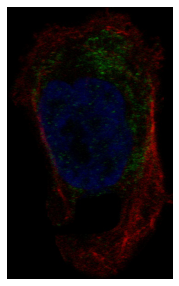

In [12]:
def get_x(r): 
    return 'C:/Users/avina/Desktop/HPA/cells/'+(r['image_id']+'_'+str(r['cell_id'])+'.jpg')


img = get_x(train_dfs.loc[5])
img = PILImage.create(img)
img.show();

In [13]:
def get_y(r): 
    return r['image_labels'].split('|')

get_y(train_dfs.loc[0])

['9', '0']

In [14]:
sample_stats = ([0.07290461, 0.04505656, 0.07713918] , [0.1727259 , 0.10327134, 0.14257778])

In [15]:
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(flip_vert=True, size=128, max_warp=0), Normalize.from_stats(*sample_stats)]
bs=64

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),
                splitter=ColSplitter(col='is_valid'),
                get_x=get_x,
                get_y=get_y,
                item_tfms=item_tfms,
                batch_tfms=batch_tfms,
                )
dls = dblock.dataloaders(train_dfs, bs=bs)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


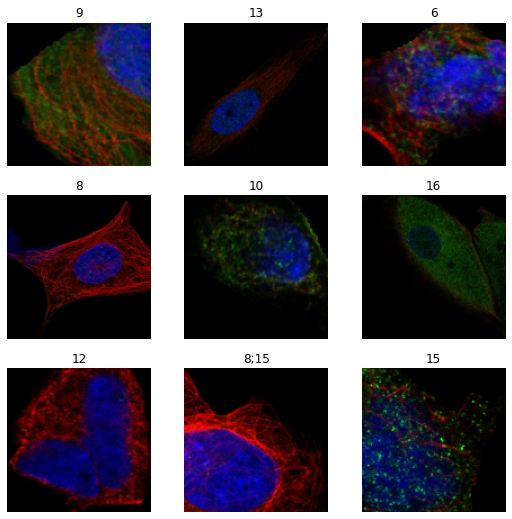

In [17]:
dls.show_batch(nrows=3, ncols=3)

In [18]:
learn = cnn_learner(dls, models.densenet121, metrics=[accuracy_multi, PrecisionMulti()]).to_fp16()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0691830962896347)

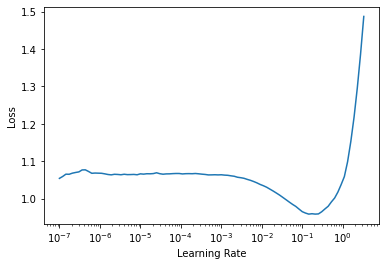

In [19]:
torch.cuda.empty_cache()
learn.lr_find()

In [20]:
lr=6e-2

In [21]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
learn = cnn_learner(dls, models.densenet121, metrics=[accuracy_multi, PrecisionMulti()]).to_fp16()
learn.fine_tune(20,base_lr=lr)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.366251,0.308374,0.915423,0.097988,07:57


epoch,train_loss,valid_loss,accuracy_multi,precision_score,time
0,0.219576,0.213979,0.936543,0.131579,08:27
1,0.220374,0.211491,0.936565,0.097554,08:12
2,0.221549,0.214917,0.936717,0.203345,08:32
3,0.227093,0.216912,0.936544,0.174386,07:39
4,0.227464,0.216200,0.936580,0.116152,07:35
5,0.228604,0.220935,0.936522,0.124561,07:48
6,0.229714,0.218960,0.936435,0.102956,07:33
7,0.228240,0.226671,0.936305,0.086745,07:33
8,0.227008,0.220292,0.936500,0.107556,09:18
9,0.226575,0.217628,0.936551,0.229802,08:35


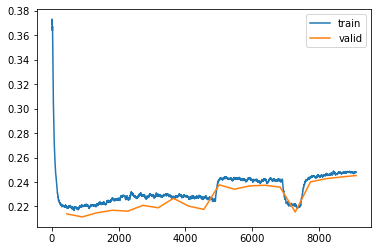

In [22]:
learn.recorder.plot_loss()

In [23]:
learn.save('C:/Users/avina/Desktop/HPA/densenet_HPA_Epoch')

Path('C:/Users/avina/Desktop/HPA/densenet_HPA.pth')